## Notebook setup

In [1]:
# dependencies

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from numpy import sqrt

from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import Holt 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


In [2]:
#reading data from file
train = pd.read_csv(r'C:/Testing/DA/predictFutureSalesClean.csv')
test = pd.read_csv('C:/Testing/DA/test.csv')
sample_submission = pd.read_csv('C:/Testing/DA/sample_submission.csv')
items = pd.read_csv('C:/Testing/DA/items.csv')
item_cats = pd.read_csv('C:/Testing/DA/item_categories.csv')
shops = pd.read_csv('C:/Testing/DA/shops.csv')

## 4. Model predicting  

### 4.1 Preparation for model predicting

In [3]:
all_data_by_day = train
all_data_by_day['date'] = pd.to_datetime(all_data_by_day['date'])
all_data_by_day = all_data_by_day.set_index('date')
all_data_by_day = all_data_by_day['2013-01-01':'2015-10-31'].resample('D').sum()
all_data_by_day

,Unnamed: 0,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,Required,date_month,date_year,total_sales
date,,,,,,,,,,,
2013-01-01,4761583,0,11703,3506646,2.401346e+05,448.0,14948,355.0,355,714615,286395.59
2013-01-02,16588954,0,42896,12593934,1.002013e+06,1788.0,55024,1359.0,1359,2735667,1258654.76
2013-01-03,15443625,0,38137,11743441,8.866805e+05,1622.0,52795,1268.0,1268,2552484,1131019.36
2013-01-04,13838761,0,34187,10155776,7.941401e+05,1390.0,45953,1125.0,1125,2264625,965669.29
2013-01-05,14059543,0,33890,10474918,7.949034e+05,1373.0,46563,1131.0,1131,2276703,955022.60
...,...,...,...,...,...,...,...,...,...,...,...
2015-10-27,1807072267,42108,41437,13307202,1.813260e+06,1474.0,52859,1276.0,12760,2571140,2211635.13
2015-10-28,1682944824,39204,37110,12298356,1.537788e+06,3555.0,49449,1188.0,11880,2393820,1696390.10
2015-10-29,1913242703,44517,42604,14158867,1.643146e+06,1535.0,56456,1349.0,13490,2718235,1822707.40


In [4]:
y_to_train = all_data_by_day[:'2015-05-31'] # dataset to train
y_to_val = all_data_by_day['2015-06-01':] # last X months for test  
predict_date = len(all_data_by_day) - len(all_data_by_day[:'2015-06-01']) # the number of data points for the test set


In [5]:
#train = pd.read_csv(r'C:/Testing/DA/predictFutureSalesClean.csv')

In [6]:
# Only keep date & item_cnt_day
Forecast_IP = train[['date','item_cnt_day']]
Forecast_IP['date'] = pd.to_datetime(Forecast_IP['date'])
# Set date as index
Forecast_IP = Forecast_IP.set_index('date')
## Select time period for weekly aggregation
Forecast_IP_weekly = Forecast_IP['2013-01-01':'2015-10-31'].resample('W').sum()
Forecast_IP_weekly

<ipython-input-6-5835c219f514>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Forecast_IP['date'] = pd.to_datetime(Forecast_IP['date'])


,item_cnt_day
date,
2013-01-06,7891.0
2013-01-13,6505.0
2013-01-20,5755.0
2013-01-27,6125.0
2013-02-03,5551.0
...,...
2015-10-04,17857.0
2015-10-11,12808.0
2015-10-18,14922.0


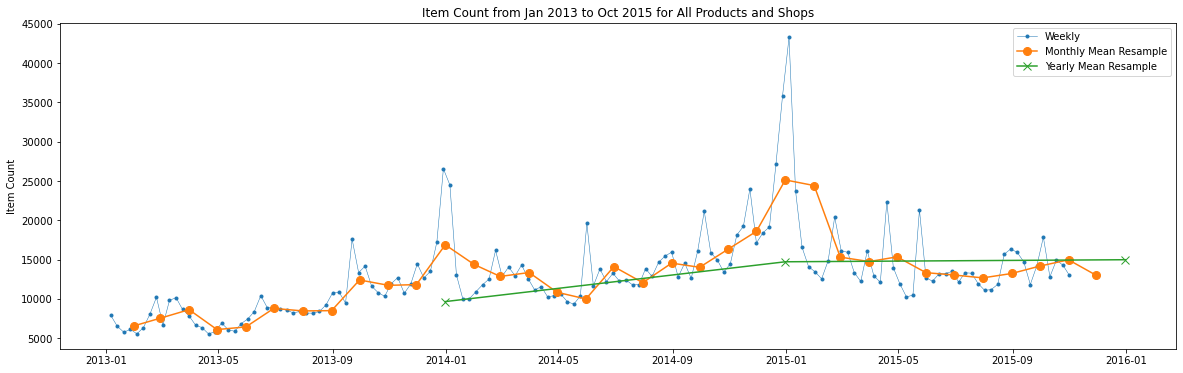

In [7]:
y = Forecast_IP_weekly['item_cnt_day']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(y.resample('Y').mean(),marker='x', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('Item Count')
ax.set_title('Item Count from Jan 2013 to Oct 2015 for All Products and Shops')
ax.legend();

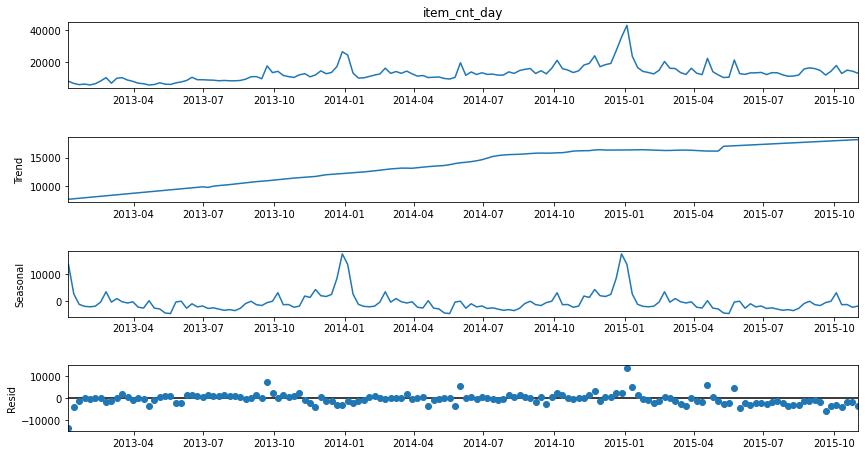

In [8]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose(y)

In [9]:
normData_filtered = train[['date','item_cnt_day','item_category_id']]

In [10]:

#create unique list of names
UniqueNames = normData_filtered.item_category_id.unique()

#create a data frame dictionary to store your data frames
df = {elem : pd.DataFrame for elem in UniqueNames}

for key in df.keys():
    df[key] = normData_filtered[:][normData_filtered.item_category_id == key]

In [11]:
count=0
for elem in df:
    count+=1
print('Total Item Category is {}'.format(count))

Total Item Category is 60


In [12]:
# Only keep date & item_cnt_day
Forecast_IP_item20 = df[20][['date','item_cnt_day']]
Forecast_IP_item20['date'] = pd.to_datetime(Forecast_IP_item20['date'])
# Set date as index
Forecast_IP_item20 = Forecast_IP_item20.set_index('date')
## Select time period for weekly aggregation
Forecast_IP_item20_weekly = Forecast_IP_item20['2013-01-01':'2015-10-31'].resample('W').sum()
Forecast_IP_item20_weekly

<ipython-input-12-82b882e204ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Forecast_IP_item20['date'] = pd.to_datetime(Forecast_IP_item20['date'])


,item_cnt_day
date,
2013-11-24,65.0
2013-12-01,1680.0
2013-12-08,725.0
2013-12-15,453.0
2013-12-22,792.0
...,...
2015-10-04,941.0
2015-10-11,1233.0
2015-10-18,1436.0


In [13]:
## Validate the start date of item category 20
df_validate = train.loc[train['item_category_id']==20]
df_validate= df_validate.sort_values(by='date')

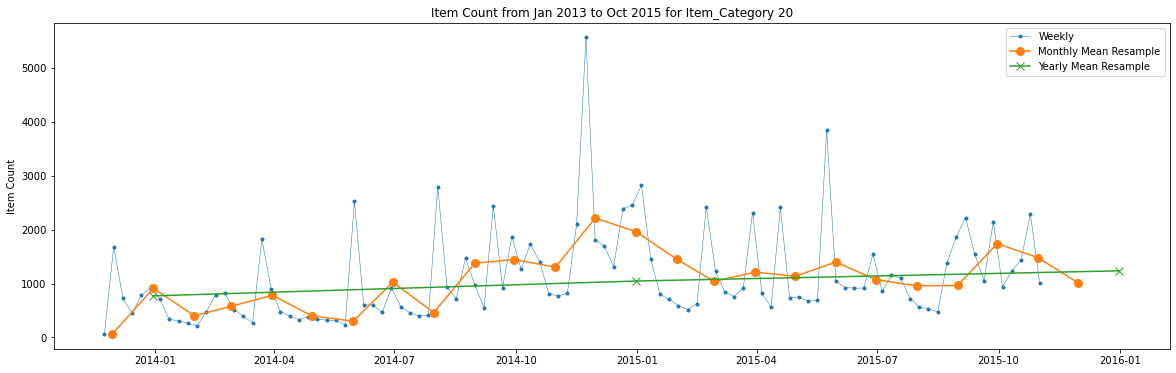

In [14]:
y = Forecast_IP_item20_weekly['item_cnt_day']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(y.resample('Y').mean(),marker='x', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('Item Count')
ax.set_title('Item Count from Jan 2013 to Oct 2015 for Item_Category 20')
ax.legend();

In [15]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y,model='additive', freq=30)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

In [16]:
# Check the date at 70% of the dataset
Forecast_IP_item20_weekly.iloc[int(len(y)*0.7)]

item_cnt_day    820.0
Name: 2015-04-05 00:00:00, dtype: float64

In [17]:
y_to_train = y[:'2015-04-05'] # dataset to train
y_to_val = y['2015-04-06':] # last X months for test  
predict_date = (len(y) - len(y[:'2015-04-06'])) # the number of data points for the test set

In [18]:
predict_date

30

### 4.2 Holt’s Linear Trend Method

Holt method helps to forecast time series data that has a trend by expanding the SES method. SES method introduces level smooting parameter (α) and Holt methods introduces trend smoothing parameter (β*). 
Both parameters (α and β*) are in the range between 0 to 1. 

There are 2 Holt's model. 
1. Holt's additive model
2. Exponential model

Exponential model is not discussed in here as it is more appropriate for situations where the increase or decrease starts slowly at the beginning and then accelrates rapidly later. 


In [19]:




def holt(y, y_to_train,y_to_test,smoothing_level, smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's Liner Trend")
    # specific smoothing level
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    
    plt.show()



The Root Mean Squared Error of Holts Linear trend 723.94


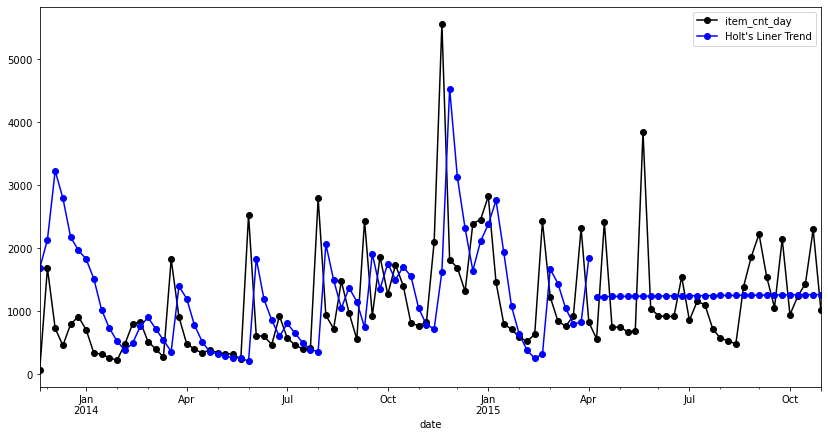

In [20]:
plt.figure()
holt(y, y_to_train, y_to_val, 0.6, 0.2, predict_date)

### 4.3 Holt-Winters’ Seasonal Method

The Holt-Winters model extends from Holt Linear method to allow the forecasting of time series data that has both trend and seasonaility. This method introduces seasonality smoothing parameter: γ

There are 2 types of seasonality
1. Additive - Seasonal changes in the data stay roughly the same over time and don't fluctuate in relation to the overall data
2. Multiplicative - Seasonal variation changes in relation to the overal changes in the data. Thus, if the data is trending upward, the seasonal differences grow proportionally as well. 

As the seasonality of our data is additive, thus, we will only discuss additive seasonality here. 

In [21]:


def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()
        
        


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=20 and a Box-Cox transformation 1013.12
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=20 and a Box-Cox transformation 819.34


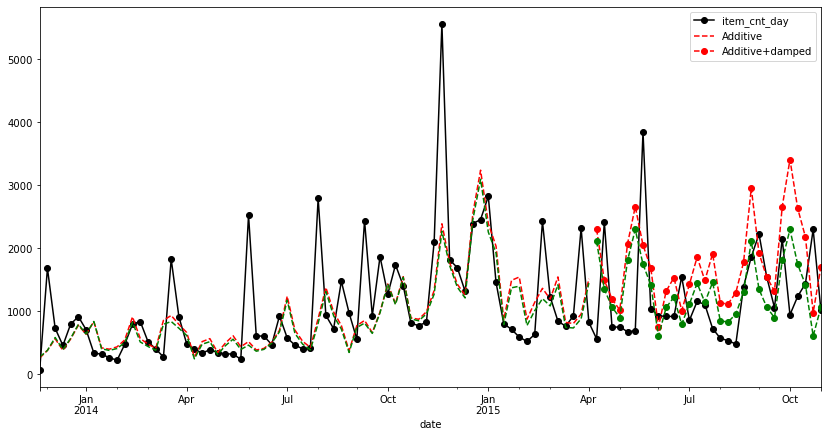

In [22]:
holt_win_sea(y, y_to_train,y_to_val,'additive',20, predict_date)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1071289                alpha                 True
smoothing_slope               2.762e-35                 beta                 True
smoothing_seasonal           1.7363e-20                gamma                 True
initial_level                 1018.3605                  l.0                 True
initial_slope                 8.3570866                  b.0                 True
initial_seasons.0            -492.86225                  s.0                 True
initial_seasons.1            -446.93824                  s.1                 True
initial_seasons.2            -793.44730                  s.2                 True
initial_seasons.3            -390.42197                  s.3                 True
initial_seasons.4            -180.47744                  s.4                 True
initial_seasons.

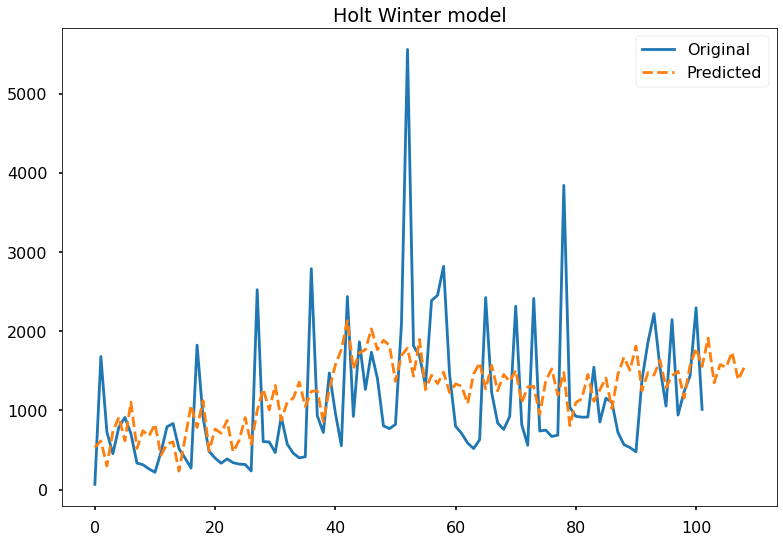

In [23]:
# Holt-Winters’ Seasonal Method  
model = HWES(y, seasonal_periods=12, trend='add', seasonal='add')
model_fit = model.fit()
print(model_fit.summary().tables[1])

# make prediction
yhat = model_fit.predict(12, len(y)+18) # predict N ahead of the last one

dataList = list(y)
yhatList = list(yhat)

plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList, label='Original')
plt.plot(yhatList, ls='--', label='Predicted')
plt.legend(loc='best')
plt.title('Holt Winter model')
plt.show()


In [24]:
# Evaluation Score

rmse = sqrt(mean_squared_error(dataList,yhatList[0:102]))
print('Holt Winter RMSE: %.1f' % rmse)

mae = mean_absolute_error(dataList,yhatList[0:102])
print('Holt Winter MAE: %.1f' % mae)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(dataList,yhatList[0:102])
print('Holt Winter MAPE: %.1f' % mape)

Holt Winter RMSE: 767.5
Holt Winter MAE: 576.2
Holt Winter MAPE: 78.1


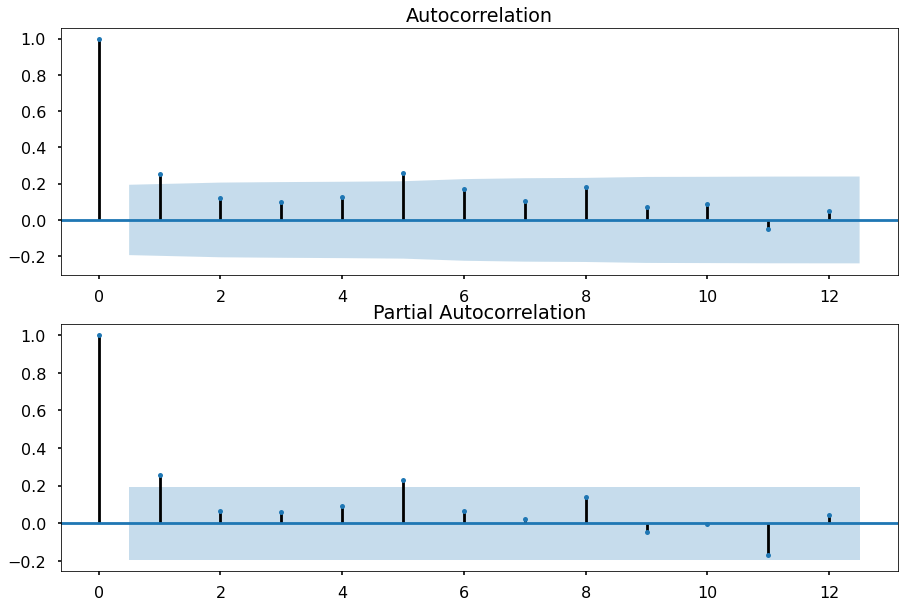

In [25]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
# Get p and q for Holt Winter

plt.figure(figsize=(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(y, lags=12, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(y, lags=12, ax=ax)
#plt.tight_layout()
plt.show()